In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gurobipy as gp
from gurobipy import GRB

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [42]:
results_production = pd.read_csv('results_production.csv', delimiter=',') 
results_unit_commitment = pd.read_csv('results_unit_comitment.csv', delimiter=',')

In [43]:
results_production.head()

,hour,generation 1,generation 2,generation 3,wind generation 1,wind generation 2,load 1,load 2,load 3,epsilon 1,...,transmission_up_binding_L3,transmission_down_binding_L3,transmission_up_binding_L4,transmission_down_binding_L4,transmission_up_binding_L5,transmission_down_binding_L5,transmission_up_binding_L6,transmission_down_binding_L6,transmission_up_binding_L7,transmission_down_binding_L7
0,0,100.0,0.0,10.000000,0.0,5.044859,7.190304,57.522429,50.332126,0.0,...,False,False,False,False,False,False,False,False,False,False
1,1,100.0,0.0,10.000000,0.0,7.889218,7.368076,58.944609,51.576533,0.0,...,False,False,False,False,False,False,False,False,False,False
2,2,100.0,0.0,10.000000,0.0,12.197143,7.637321,61.098571,53.461250,0.0,...,False,False,False,False,False,False,False,False,False,False
3,3,100.0,0.0,10.000000,0.0,5.828420,7.239276,57.914210,50.674934,0.0,...,False,False,False,False,False,False,False,False,False,False
4,4,100.0,0.0,11.403747,0.0,18.951910,8.147229,65.177829,57.030600,0.0,...,True,False,False,False,False,False,False,False,False,False


In [44]:
features = results_production[['wind generation 1', 'wind generation 2', 'load 1', 'load 2', 'load 3']]

# Use the unit commitment results as labels
labels = results_unit_commitment[['G1', 'G2', 'G3']]

# Separate features (X) and labels (y)
X = features
y = labels
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training Set: {X_train.shape}, Validation Set: {X_val.shape}, Test Set: {X_test.shape}")


Training Set: (1680, 5), Validation Set: (360, 5), Test Set: (360, 5)


In [45]:
# Check if units are always ON or OFF
print(y_train.mean())  # If mean = 1 or 0, the unit is always ON or OFF

# Filter out units that are always ON or OFF
units_to_classify = y_train.columns[(y_train.mean() > 0) & (y_train.mean() < 1)]
print(f"Units to classify: {units_to_classify}")

G1    1.000000
G2    0.272024
G3    0.964881
dtype: float64
Units to classify: Index(['G2', 'G3'], dtype='object')


In [46]:
# Linear Classifier
# Define logistic regression models for each generator
logistic_models = {}

# Loop through each generator in the labels
for unit in units_to_classify:  # e.g., 'G1', 'G2', 'G3'
    print(f"\nTraining Logistic Regression for {unit}...")

    # Extract training and validation data for this unit
    y_train_unit = y_train[unit]
    y_val_unit = y_val[unit]

    # Initialize and train the logistic regression model
    logistic = LogisticRegression(random_state=42)
    logistic.fit(X_train, y_train_unit)
    logistic_models[unit] = logistic

    # Predict on validation set
    y_pred_val = logistic.predict(X_val)

    # Evaluate performance
    accuracy = accuracy_score(y_val_unit, y_pred_val)
    print(f"Validation Accuracy for {unit}: {accuracy}")
    print(classification_report(y_val_unit, y_pred_val))



Training Logistic Regression for G2...
Validation Accuracy for G2: 0.9083333333333333
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.93       259
         1.0       0.80      0.89      0.85       101

    accuracy                           0.91       360
   macro avg       0.88      0.90      0.89       360
weighted avg       0.91      0.91      0.91       360


Training Logistic Regression for G3...
Validation Accuracy for G3: 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        16
         1.0       1.00      1.00      1.00       344

    accuracy                           1.00       360
   macro avg       1.00      1.00      1.00       360
weighted avg       1.00      1.00      1.00       360



In [47]:
## Non-Linear Classifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Define SVM models for each generator
svm_models = {}

# Loop through each generator in the labels
for unit in units_to_classify:  # e.g., 'G1', 'G2', 'G3'
    print(f"\nTraining SVM (RBF Kernel) for {unit}...")

    # Extract training and validation data for this unit
    y_train_unit = y_train[unit]
    y_val_unit = y_val[unit]

    # Initialize and train the SVM model
    svm = SVC(kernel='rbf', random_state=42)
    svm.fit(X_train, y_train_unit)
    svm_models[unit] = svm

    # Predict on validation set
    y_pred_val = svm.predict(X_val)

    # Evaluate performance
    accuracy = accuracy_score(y_val_unit, y_pred_val)
    print(f"Validation Accuracy for {unit}: {accuracy}")
    print(classification_report(y_val_unit, y_pred_val))



Training SVM (RBF Kernel) for G2...
Validation Accuracy for G2: 0.9138888888888889
              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94       259
         1.0       0.84      0.86      0.85       101

    accuracy                           0.91       360
   macro avg       0.89      0.90      0.89       360
weighted avg       0.91      0.91      0.91       360


Training SVM (RBF Kernel) for G3...
Validation Accuracy for G3: 0.9666666666666667
              precision    recall  f1-score   support

         0.0       1.00      0.25      0.40        16
         1.0       0.97      1.00      0.98       344

    accuracy                           0.97       360
   macro avg       0.98      0.62      0.69       360
weighted avg       0.97      0.97      0.96       360



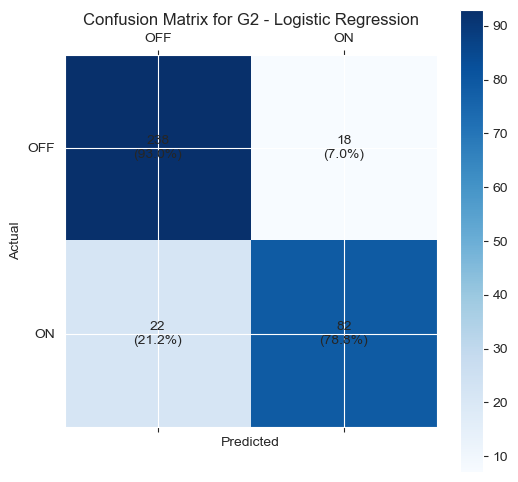

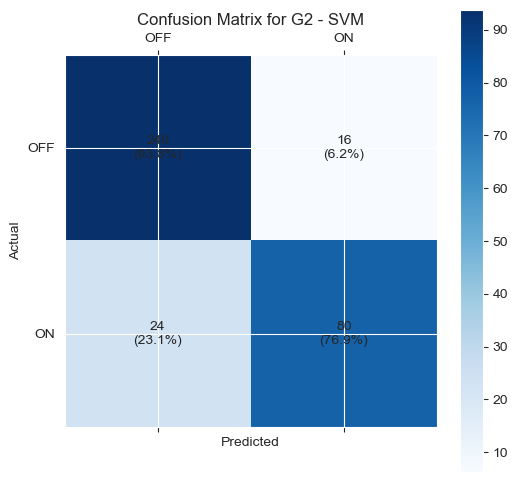

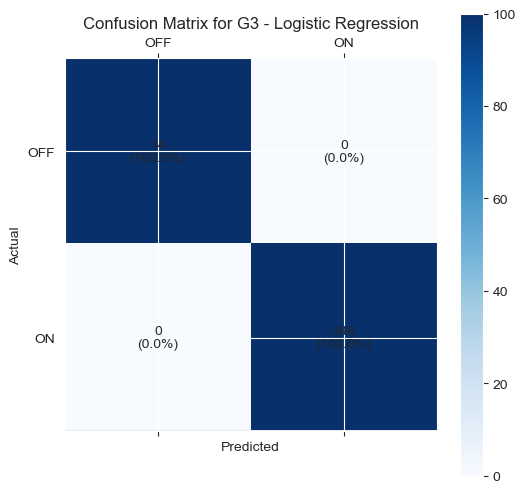

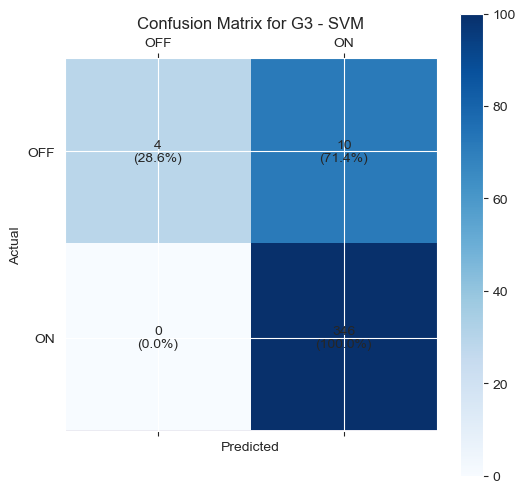

In [52]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Function to plot confusion matrix with percentages
def plot_confusion_matrix(cm, classes, title, cmap='Blues'):
    """
    Plots a confusion matrix with percentages alongside raw values.
    Args:
        cm: Confusion matrix (2D array)
        classes: List of class labels (e.g., ['OFF', 'ON'])
        title: Title for the plot
        cmap: Color map for the visualization
    """
    # Normalize confusion matrix to percentages
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    fig, ax = plt.subplots(figsize=(6, 6))
    cax = ax.matshow(cm_percentage, cmap=cmap)
    fig.colorbar(cax)

    # Annotate confusion matrix with raw counts and percentages
    for (i, j), value in np.ndenumerate(cm):
        ax.text(
            j, i, f"{value}\n({cm_percentage[i, j]:.1f}%)", ha="center", va="center", fontsize=10
        )

    # Set axis labels and ticks
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()


# Iterate over units ('G2', 'G3') and models ('Logistic Regression', 'SVM')
for unit in ['G2', 'G3']:
    for model_name, model in [('Logistic Regression', logistic_models[unit]), ('SVM', svm_models[unit])]:
        
        # Get true labels and predictions for the test set
        y_true = y_test[unit]  # True labels
        y_pred = model.predict(X_test)  # Model predictions

        # Compute the confusion matrix
        cm = confusion_matrix(y_true, y_pred)

        # Plot confusion matrix with percentages
        plot_confusion_matrix(
            cm,
            classes=['OFF', 'ON'],
            title=f"Confusion Matrix for {unit} - {model_name}"
        )


In [ ]:
#Evaluate Models
from sklearn.metrics import accuracy_score, classification_report

# Evaluate all models on the test set
for unit in units_to_classify:  # e.g., 'G1', 'G2', 'G3'
    print(f"\nEvaluating models for {unit}:")

    # Logistic Regression
    logistic_model = logistic_models[unit]  # Retrieve the trained logistic regression model
    y_pred_test_logistic = logistic_model.predict(X_test)  # Predict on the test set
    print(f"Logistic Regression Test Accuracy for {unit}: {accuracy_score(y_test[unit], y_pred_test_logistic)}")
    print(classification_report(y_test[unit], y_pred_test_logistic))

    # SVM
    svm_model = svm_models[unit]  # Retrieve the trained SVM model
    y_pred_test_svm = svm_model.predict(X_test)  # Predict on the test set
    print(f"SVM Test Accuracy for {unit}: {accuracy_score(y_test[unit], y_pred_test_svm)}")
    print(classification_report(y_test[unit], y_pred_test_svm))